In [327]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from datetime import date
pd.set_option('display.max_columns', None)

In [198]:
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False)

In [199]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [200]:
df.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [201]:
df.shape

(2075259, 9)

#### Memory check and data types change

In [202]:
memory = df.memory_usage().sum() / 1024**2
print('Memory usage of dataframe before any changes is {:.2f} MB'.format(memory))

Memory usage of dataframe before any changes is 142.50 MB


In [203]:
for col in df.columns:
    col_type = df[col].dtype
    
    print('---------')
    if col  == 'Date' and col_type == 'object':
        print(f"{col} : {col_type}")
        df[col] = df[col].apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))
        #df[col] = pd.to_datetime(df[col], infer_datetime_format=True)
        print(f"New col type: {df[col].dtype}")
              
    elif col  == 'Time' and col_type == 'object':
        print(f"{col} : {col_type}")
        df[col] = df[col].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())
        #df[col] = pd.to_datetime(df[col], format='%H:%M')
        print(f"New col type: {df[col].dtype}")
              
    elif col.startswith('Sub'):
        print(f"{col} : {col_type}")
        df[col] = pd.to_numeric(df[col], errors='coerce')
        c_min, c_max = df[col].min(), df[col].max()
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
            df[col] = df[col].astype(pd.Int8Dtype(), errors='ignore')
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
            df[col] = df[col].astype(pd.Int16Dtype(), errors='ignore')
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            df[col] = df[col].astype(pd.Int32Dtype(), errors='ignore')
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
            df[col] = df[col].astype(pd.Int64Dtype(), errors='ignore')
        print(f"New col type: {df[col].dtype}")
              
    else:
        print(f"{col} : {col_type}")
        df[col] = pd.to_numeric(df[col], errors='coerce')
        c_min, c_max = df[col].min(), df[col].max()
        if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
            df[col] = df[col].astype(np.float16)
        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype(np.float64)
        print(f"New col type: {df[col].dtype}")

---------
Date : object
New col type: datetime64[ns]
---------
Time : object
New col type: object
---------
Global_active_power : object
New col type: float16
---------
Global_reactive_power : object
New col type: float16
---------
Voltage : object
New col type: float16
---------
Global_intensity : object
New col type: float16
---------
Sub_metering_1 : object
New col type: Int8
---------
Sub_metering_2 : object
New col type: Int8
---------
Sub_metering_3 : float64
New col type: Int8


In [204]:
new_memory = df.memory_usage().sum() / 1024**2
print('New Memory usage of dataframe after changes is {:.2f} MB'.format(new_memory))

New Memory usage of dataframe after changes is 59.37 MB


In [205]:
df.dtypes

Date                     datetime64[ns]
Time                             object
Global_active_power             float16
Global_reactive_power           float16
Voltage                         float16
Global_intensity                float16
Sub_metering_1                     Int8
Sub_metering_2                     Int8
Sub_metering_3                     Int8
dtype: object

In [206]:
def combine(date, time):
    return datetime.combine(date,time)

df['DateTime'] = df.apply(lambda row: combine(row['Date'], row['Time']), axis=1)

In [207]:
new_memory = df.memory_usage().sum() / 1024**2
print('New Memory usage of dataframe after changes is {:.2f} MB'.format(new_memory))

New Memory usage of dataframe after changes is 75.21 MB


### Checking missing values

In [213]:
# Any missing values in time frequency

min_stamp, max_stamp = df.DateTime.min(), df.DateTime.max()
complete_date_range = pd.date_range(start=min_stamp, end=max_stamp, freq='T')

print(len(complete_date_range), '||||', len(df.DateTime.values))
print('Same lenght - so no missing values')
print('====================================================')
print('Minimum and maximum time stamps in the data')
print(min_stamp, '||||', max_stamp)

2073600 |||| 2073600
Same lenght - so no missing values
Minimum and maximum time stamps in the data
2006-12-17 00:00:00 |||| 2010-11-25 23:59:00


- We do not have all day information for dates `2006-12-16` and `2010-11-26`
- To make some daily or hourly studies, it is better to drop them. (Will drop them later) 

In [214]:
df.isnull().sum()

Date                          0
Time                          0
Global_active_power       25979
Global_reactive_power     25979
Voltage                   25979
Global_intensity          25979
Sub_metering_1            25979
Sub_metering_2            25979
Sub_metering_3            25979
DateTime                      0
Global_active_energy      25979
Global_reactive_energy    25979
dtype: int64

In [215]:
df.Global_active_power.isnull().sum()/len(df) 

0.012528452932098765

- We see around 1.25% missing values in all columns (not including the date time)

### Creating New Columns

- Our Sub metering columns and our target should be of the units Wh or KWh. 
- We need to convert the power columns which are in KW units to energy which would be in KWh
- This can be done diving the power by 60 as our frequency is one minute

In [216]:
df['Global_active_energy'] = df.Global_active_power*1000/60
df['Global_reactive_energy'] = df.Global_reactive_power*1000/60

Before we fill null values, we try to understand more about the data. We also drop the first and last days, as they dont have the whole data

In [217]:
df = df.loc[(df['DateTime'].dt.date > date(2006, 12, 16)) & 
             (df['DateTime'].dt.date < date(2010, 11, 26)), : ]

#### Groupbys 

Creating hourly and daily grouped data to understand seasonality, as we cann see that evident in a 1 min interval plots

### Daily

In [218]:
daily = df.fillna(-10).groupby(df['DateTime'].dt.date).agg({'Global_active_power':'mean', 'Global_reactive_power':'mean',
                                                        'Sub_metering_1': sum, 'Sub_metering_2': sum, 'Sub_metering_3': sum,
                                                        'Global_active_energy': sum, 'Global_reactive_energy': sum})

## Filling it with -10 to have a clear distinction for missing values. 

In [219]:
daily.head(2)

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_energy,Global_reactive_energy
DateTime,,,,,,,
2006-12-17,2.353516,0.156982,2033,4187,13341,56507.589844,3766.787842
2006-12-18,1.530273,0.112366,1063,2621,14018,36730.460938,2696.489990


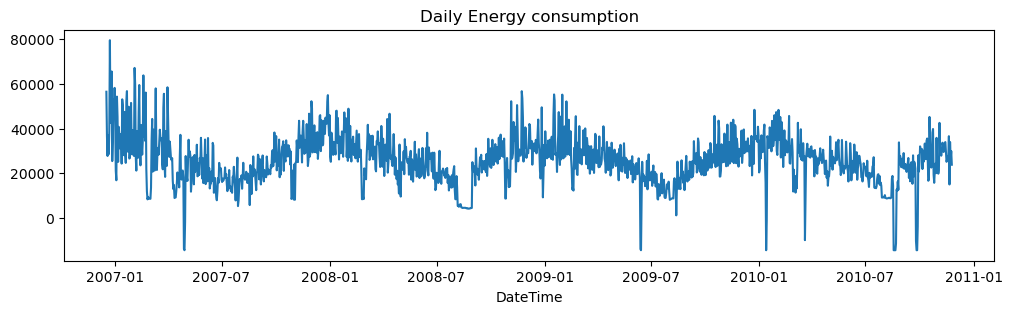

In [220]:
daily.Global_active_energy.plot(figsize=(12,3))
plt.title('Daily Energy consumption')
plt.show()

- We can see clear seasonality and maybe a slight downward trend. 
- The negative values of the days are where the missing values are. (We added a negative value)

### Hourly

In [221]:
hourly = df.fillna(-1).groupby([df['Date'], df['DateTime'].dt.hour]).agg({'Global_active_power':'mean', 'Global_reactive_power':'mean',
                                                    'Sub_metering_1': sum, 'Sub_metering_2': sum, 'Sub_metering_3': sum,
                                                    'Global_active_energy':sum, 'Global_reactive_energy':sum})

In [222]:
hourly.reset_index(inplace=True)

In [223]:
hourly.head(3)

,Date,DateTime,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_energy,Global_reactive_energy
0,2006-12-17,0,1.882812,0.102417,0,28,0,1882.336426,102.429199
1,2006-12-17,1,3.349609,0.136963,0,1514,0,3349.369385,136.934402
2,2006-12-17,2,1.586914,0.078247,0,34,0,1587.186646,78.229271


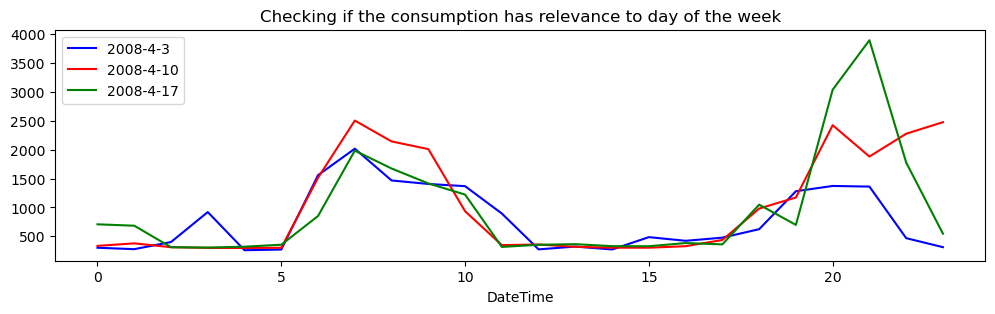

In [224]:
fig, ax = plt.subplots(figsize=(12,3))

hourly.loc[hourly['Date'] == '2008-4-3', ['DateTime','Global_active_energy']].plot(x='DateTime', y='Global_active_energy', ax=ax, color='b')
hourly.loc[hourly['Date'] == '2008-4-10', ['DateTime','Global_active_energy']].plot(x='DateTime', y='Global_active_energy', ax=ax, color='r')
hourly.loc[hourly['Date'] == '2008-4-17', ['DateTime','Global_active_energy']].plot(x='DateTime', y='Global_active_energy', ax=ax, color='g')

ax.legend(['2008-4-3', '2008-4-10', '2008-4-17'])
plt.title('Checking if the consumption has relevance to day of the week')
plt.show()

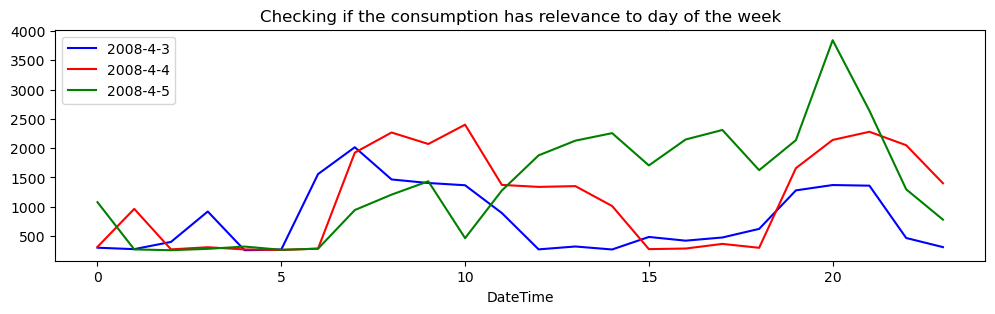

In [225]:
fig, ax = plt.subplots(figsize=(12,3))

hourly.loc[hourly['Date'] == '2008-4-3', ['DateTime','Global_active_energy']].plot(x='DateTime', y='Global_active_energy', ax=ax, color='b')
hourly.loc[hourly['Date'] == '2008-4-4', ['DateTime','Global_active_energy']].plot(x='DateTime', y='Global_active_energy', ax=ax, color='r')
hourly.loc[hourly['Date'] == '2008-4-5', ['DateTime','Global_active_energy']].plot(x='DateTime', y='Global_active_energy', ax=ax, color='g')

ax.legend(['2008-4-3', '2008-4-4', '2008-4-5'])
plt.title('Checking if the consumption has relevance to day of the week')
plt.show()

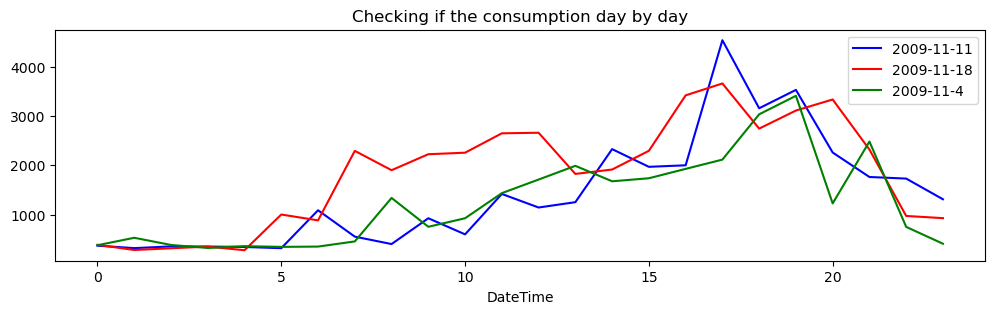

In [226]:
fig, ax = plt.subplots(figsize=(12,3))

hourly.loc[hourly['Date'] == '2009-11-11', ['DateTime','Global_active_energy']].plot(x='DateTime', y='Global_active_energy', ax=ax, color='b')
hourly.loc[hourly['Date'] == '2009-11-18', ['DateTime','Global_active_energy']].plot(x='DateTime', y='Global_active_energy', ax=ax, color='r')
hourly.loc[hourly['Date'] == '2009-11-4', ['DateTime','Global_active_energy']].plot(x='DateTime', y='Global_active_energy', ax=ax, color='g')

ax.legend(['2009-11-11', '2009-11-18', '2009-11-4'])
plt.title('Checking if the consumption day by day')
plt.show()

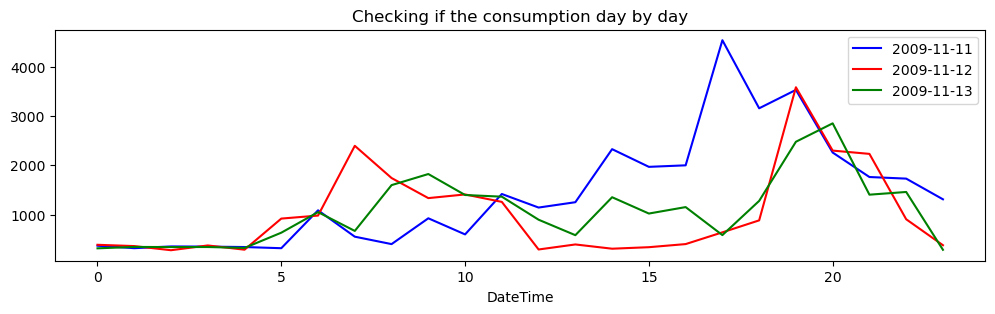

In [227]:
fig, ax = plt.subplots(figsize=(12,3))

hourly.loc[hourly['Date'] == '2009-11-11', ['DateTime','Global_active_energy']].plot(x='DateTime', y='Global_active_energy', ax=ax, color='b')
hourly.loc[hourly['Date'] == '2009-11-12', ['DateTime','Global_active_energy']].plot(x='DateTime', y='Global_active_energy', ax=ax, color='r')
hourly.loc[hourly['Date'] == '2009-11-13', ['DateTime','Global_active_energy']].plot(x='DateTime', y='Global_active_energy', ax=ax, color='g')

ax.legend(['2009-11-11', '2009-11-12', '2009-11-13'])
plt.title('Checking if the consumption day by day')
plt.show()

- From the hourly graphs, we can se that a days data has more relation to the next week's same day, rather than than the next day
- We can also check the correlation values 

In [228]:
def get_corr_value(date1, date2):
    s1 = hourly.loc[hourly['Date'] == date1, 'Global_active_energy'].reset_index(drop=True)
    s2 = hourly.loc[hourly['Date'] == date2, 'Global_active_energy'].reset_index(drop=True)
    return s1.corr(s2)

In [229]:
print('Checking Correlation values for 2009-11-11')
print('************************************************')
print('Corellation value for consecutive days. Between 2009-11-11 and 2009-11-12 is', get_corr_value('2009-11-11','2009-11-12'))
print('-----------------------------------------------------------------')
print('Corellation value for consecutive days. Between 2009-11-11 and 2009-11-10 is', get_corr_value('2009-11-11','2009-11-10'))
print('-----------------------------------------------------------------')
print('Corellation value for next weeks day. Between 2009-11-11 and 2009-11-18 is', get_corr_value('2009-11-11','2009-11-18'))
print('-----------------------------------------------------------------')
print('Corellation value for next weeks day. Between 2009-11-11 and 2009-11-4 is', get_corr_value('2009-11-11','2009-11-4'))



Checking Correlation values for 2009-11-11
************************************************
Corellation value for consecutive days. Between 2009-11-11 and 2009-11-12 is 0.2553871097888951
-----------------------------------------------------------------
Corellation value for consecutive days. Between 2009-11-11 and 2009-11-10 is 0.24737801096731077
-----------------------------------------------------------------
Corellation value for next weeks day. Between 2009-11-11 and 2009-11-18 is 0.7229183356973586
-----------------------------------------------------------------
Corellation value for next weeks day. Between 2009-11-11 and 2009-11-4 is 0.7799831211425511


In [230]:
print('Checking Correlation values for 2008-4-4')
print('************************************************')
print('Corellation value for consecutive days. Between 2008-4-3 and 2008-4-4 is', get_corr_value('2008-4-3','2008-4-4'))
print('-----------------------------------------------------------------')
print('Corellation value for consecutive days. Between 2008-4-4 and 2008-4-5 is', get_corr_value('2008-4-4','2008-4-5'))
print('-----------------------------------------------------------------')
print('Corellation value for next weeks day. Between 2008-4-3 and 2008-4-10 is', get_corr_value('2008-4-3','2008-4-10'))
print('-----------------------------------------------------------------')
print('Corellation value for next weeks day. Between 2008-4-4 and 2008-3-27 is', get_corr_value('2008-4-3','2008-3-27'))

Checking Correlation values for 2008-4-4
************************************************
Corellation value for consecutive days. Between 2008-4-3 and 2008-4-4 is 0.5819218649337707
-----------------------------------------------------------------
Corellation value for consecutive days. Between 2008-4-4 and 2008-4-5 is 0.3339422602551628
-----------------------------------------------------------------
Corellation value for next weeks day. Between 2008-4-3 and 2008-4-10 is 0.6470606983673737
-----------------------------------------------------------------
Corellation value for next weeks day. Between 2008-4-4 and 2008-3-27 is 0.6833517611170529


#### How can we use the above information?
- Can utilize this information to fill the missing values.
- Some of the dates have total missing data and they are consecutive. In that case, we can just you the previous weeks data to fill the current data. 
- When there are only 1 or 2 rows missing in a day, we will just perform forward or backward fill.

In [233]:
missing_dates = df[df.Global_active_power.isna()].groupby([df['DateTime'].dt.date], as_index=False).size()
missing_dates.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81
DateTime,2006-12-21,2006-12-30,2007-01-14,2007-01-28,2007-02-22,2007-03-25,2007-04-28,2007-04-29,2007-04-30,2007-06-01,2007-06-06,2007-06-09,2007-06-19,2007-06-29,2007-07-15,2007-07-22,2007-08-01,2007-08-24,2007-09-26,2007-10-23,2007-11-21,2007-11-29,2007-12-17,2008-01-13,2008-02-02,2008-02-23,2008-03-24,2008-05-16,2008-06-13,2008-07-13,2008-08-04,2008-08-31,2008-10-25,2008-11-10,2008-11-12,2008-11-23,2008-12-10,2008-12-20,2009-01-14,2009-02-01,2009-02-14,2009-02-17,2009-03-01,2009-03-16,2009-04-13,2009-05-10,2009-05-26,2009-06-13,2009-06-14,2009-06-15,2009-07-10,2009-08-13,2009-09-13,2009-09-30,2009-10-11,2009-11-09,2009-12-10,2010-01-02,2010-01-12,2010-01-13,2010-01-14,2010-01-23,2010-02-10,2010-02-14,2010-03-20,2010-03-21,2010-04-11,2010-05-13,2010-06-12,2010-06-29,2010-07-15,2010-08-17,2010-08-18,2010-08-19,2010-08-20,2010-08-21,2010-08-22,2010-09-25,2010-09-26,2010-09-27,2010-09-28,2010-10-24
size,2,2,1,1,2,1,1419,1440,864,1,1,38,2,1,130,1,21,1,2,2,1,1,1,1,1,2,1,2,1,2,1,1,43,6,2,1,70,1,1,38,2,24,1,1,2,1,3,1410,1440,455,4,891,1,2,1,1,2,1,547,1440,1142,1,1,1,1208,819,1,1,1,1,1,178,1440,1440,1440,1440,1288,1204,1440,1440,1153,1


In [293]:
x, y, z = missing_dates.shape[0], (missing_dates['size'] <= 10).sum(), (missing_dates['size'] >= 1000).sum()

print("Total number of days with missing values: " , x)
print("Number of days with less than 10 missing values: " , y)
print("Number of days with greater than 1000 missing values: " , z)

Total number of days with missing values:  82
Number of days with less than 10 missing values:  53
Number of days with greater than 1000 missing values:  16


In [333]:
na_groups = df['Global_active_power'].notna().cumsum()[df['Global_active_power'].isna()]
len_consecutive_na = na_groups.groupby(na_groups).agg(len)

longest_na_gap = len_consecutive_na.max()
longest_na_gap

7226

In [334]:
7226/1440

5.018055555555556

#### Filling missing values for dates which have less than 500 missing values 

- Luckily all the mising values are consecutive. So we simply fill the missing values using shift.

In [345]:
df1 = df.copy()

In [384]:
df=df1.copy()

In [387]:
cols = ['Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Global_active_energy', 'Global_reactive_energy']

def fill_missing(date, n):
    print(date)
    print(n)
    temp = df[df.Date == str(date)]
    ind = temp[temp.Global_active_power.isnull()].index
    df.loc[ind, cols] = df.loc[ind-n, cols].values 
    print(f'Filled {n} missing values for {date}')

def fill_lastweek(date, n):
    print(date)
    print(n)
    lastweek = datetime.strptime(str(date), '%Y-%m-%d') - timedelta(days=7)
    df.loc[df.Date == str(date), cols] = df.loc[df.Date == lastweek, cols].values
    print(f'Filled {n} missing values for {date}')

In [388]:
for index, row in missing_dates.iterrows():
    if row[1] < 800:
        fill_missing(row[0], row[1])
    elif row[1] >= 800:
        fill_lastweek(row[0], row[1])

2006-12-21
2
Filled 2 missing values for 2006-12-21
2006-12-30
2
Filled 2 missing values for 2006-12-30
2007-01-14
1
Filled 1 missing values for 2007-01-14
2007-01-28
1
Filled 1 missing values for 2007-01-28
2007-02-22
2
Filled 2 missing values for 2007-02-22
2007-03-25
1
Filled 1 missing values for 2007-03-25
2007-04-28
1419
Filled 1419 missing values for 2007-04-28
2007-04-29
1440
Filled 1440 missing values for 2007-04-29
2007-04-30
864
Filled 864 missing values for 2007-04-30
2007-06-01
1
Filled 1 missing values for 2007-06-01
2007-06-06
1
Filled 1 missing values for 2007-06-06
2007-06-09
38
Filled 38 missing values for 2007-06-09
2007-06-19
2
Filled 2 missing values for 2007-06-19
2007-06-29
1
Filled 1 missing values for 2007-06-29
2007-07-15
130
Filled 130 missing values for 2007-07-15
2007-07-22
1
Filled 1 missing values for 2007-07-22
2007-08-01
21
Filled 21 missing values for 2007-08-01
2007-08-24
1
Filled 1 missing values for 2007-08-24
2007-09-26
2
Filled 2 missing values for

In [389]:
df.isnull().sum()

Date                      0
Time                      0
Global_active_power       9
Global_reactive_power     9
Voltage                   9
Global_intensity          9
Sub_metering_1            9
Sub_metering_2            9
Sub_metering_3            9
DateTime                  0
Global_active_energy      9
Global_reactive_energy    9
dtype: int64

In [395]:
miss = df.loc[df.Global_active_energy.isnull(), 'Date'].unique()[0]

In [394]:
df[df.Global_active_power.isna()].groupby([df['DateTime'].dt.date], as_index=False).size()

,DateTime,size
0,2007-07-15,9


In [396]:
fill_missing(miss, 9)

2007-07-15T00:00:00.000000000
9
Filled 9 missing values for 2007-07-15T00:00:00.000000000


In [397]:
df.isnull().sum()

Date                      0
Time                      0
Global_active_power       0
Global_reactive_power     0
Voltage                   0
Global_intensity          0
Sub_metering_1            0
Sub_metering_2            0
Sub_metering_3            0
DateTime                  0
Global_active_energy      0
Global_reactive_energy    0
dtype: int64

### Filled all the missing values

In [403]:
df.reset_index(drop=True, inplace=True)

In [404]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime,Global_active_energy,Global_reactive_energy
0,2006-12-17,00:00:00,1.043945,0.151978,242.750,4.398438,0,2,0,2006-12-17 00:00:00,17.399088,2.532959
1,2006-12-17,00:01:00,1.519531,0.219971,242.250,7.398438,0,1,0,2006-12-17 00:01:00,25.325521,3.666178
2,2006-12-17,00:02:00,3.037109,0.193970,240.125,12.601562,0,2,0,2006-12-17 00:02:00,50.618488,3.232829
3,2006-12-17,00:03:00,2.974609,0.193970,240.000,12.398438,0,1,0,2006-12-17 00:03:00,49.576824,3.232829
4,2006-12-17,00:04:00,2.845703,0.197998,240.375,11.796875,0,2,0,2006-12-17 00:04:00,47.428387,3.299968


### Adding the target column
- global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3
- The above formula was provided by the dataset provider. We already calculated the Global_active_energy, so our formula would be `Global_active_energy - sub_metering_1 - sub_metering_2 - sub_metering_3`

In [407]:
df['Active_Energy'] = df['Global_active_energy'] - df['Sub_metering_1'] - df['Sub_metering_2'] - df['Sub_metering_3']

In [408]:
new_memory = df.memory_usage().sum() / 1024**2
print('New Memory usage of dataframe after changes is {:.2f} MB'.format(new_memory))

New Memory usage of dataframe after changes is 100.85 MB


In [415]:
df = df[['DateTime', 'Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Global_active_energy', 'Global_reactive_energy', 'Active_Energy']]

In [416]:
df.dtypes

DateTime                  datetime64[ns]
Date                      datetime64[ns]
Time                              object
Global_active_power              float16
Global_reactive_power            float16
Voltage                          float16
Global_intensity                 float16
Sub_metering_1                      Int8
Sub_metering_2                      Int8
Sub_metering_3                      Int8
Global_active_energy             float32
Global_reactive_energy           float32
Active_Energy                    Float32
dtype: object

In [419]:
df.to_csv('cleaned.csv', index=False)